# Deep Learning based on Batch Normalisation for P300 signal detection

---




This notebook reproduces the pipeline proposed by Liu et al. for P300 classification. In our case the data comes from the BCI Competition III Dataset II only. The link to the papaer is: 
https://www.sciencedirect.com/science/article/abs/pii/S0925231217314601

# Loading of data

In [ ]:
# %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [1]:
# This code requires the interaction of the user to mount the google drive directory. 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/Project
#Now we can look at what we have inside the downloaded folder 
!ls

/content/gdrive/My Drive/Project
BCI_Comp_III_Wads_2004.zip  CNN_B.h5  model_CNN_B.png
classification_experiments  Data      model_LSTM_CNN_B.png


In [3]:
#IMPORT
import matplotlib.pyplot as plt   # Required to plot data
import numpy as np                # Management of arrays
import os                         # System utils
from pathlib import Path          # path and file utils
from scipy.io import loadmat      # Required to load .mat files
from scipy import signal          # Required for signal processing
from tqdm.auto import tqdm        # For progress bars
import tensorflow as tf           # Import tensorflow (backend of Keras)
import pandas as pd       
import seaborn as sns
from matplotlib import rc         # To visualise slider and widgets in colab 
import ipywidgets as widgets      # Slider 
import gc                         #garbage collector saves RAM memory space

### KERAS LIBRARY ###
from tensorflow import keras      # Keras is used to define the model
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Conv1D, Dropout
from keras.layers import Activation, Permute, LSTM, Dense, Flatten # For LSTM model
from keras.layers import TimeDistributed, Reshape
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import initializers

### METRICS ###
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

###Imports need for first layer output###
import glob
import matplotlib.image as mpimg
import imageio as im
from keras import models
from keras.preprocessing import image

import math

tf.keras.backend.clear_session()
tf.version

#Set the SEED for reporucibility
SEED = 1234
tf.random.set_seed(SEED)

In [4]:
### DEFINE DIRECTORIES AND LOAD MATLAB FILE ###         
data_dir = '/content/gdrive/My Drive/Project/Data'

# Dropdown colab 
# SELECT THE SUBJECT DATA
subject = 'A'#@param["A", "B"]

train_dir = os.path.join(data_dir, f'Subject_{subject}_Train.mat') 
test_dir = os.path.join(data_dir, f'Subject_{subject}_Test.mat')

data = loadmat(train_dir)

In [5]:
#CHANNEL
CHANNEL_LOCATIONS_FILE_PATH = os.path.join(data_dir, 'channels.csv')

CHANNELS = []
# Read file content
with open(CHANNEL_LOCATIONS_FILE_PATH, "r") as f:
  file_content = f.read()
  # Loop over all rows (except first one)
  for row in file_content.split("\n")[1:]: 
    # Skip missing rows
    if row == '':
      continue
    CHANNELS.append(row)

In [6]:
### LOADING OF THE DATASET ###

# The variables inside the file are arrays: 
signals = data['Signal'] # signal matrix of the EEG recording(85, 7794, 64)
flashing = data['Flashing'] # defines when an intensification occurs (1)
stimulus = data['StimulusType'] # defines if the response is P300 or non P300
word = data['TargetChar'] # array of target words 
    
f_s = 240 # sampling frequency
samples = len(signals[0]) # number of samples 
signal_duration = (len(signals))*(samples)/(f_s*60) # duration = (85 * 7794) / (240 Hz * 60) [min]
trials= len(word[0]) # Compute number of trials (characters)

print(f"TRAIN INFO SUBJECT {subject}")
print("Fs: %d Hz [%.2f ms]" % (f_s, (1000/f_s)))
print("signal duration:   %.2f min" % signal_duration)
print("letters:  %d" % trials)
print(f"Number of samples per trial: {samples}")

TRAIN INFO SUBJECT A
Fs: 240 Hz [4.17 ms]
signal duration:   46.01 min
letters:  85
Number of samples per trial: 7794


# Preprocessing 

The steps before feeding the signal into the CNN are the following: 
- 667 ms interval after the stimulus on-set 
- Filtering 8th order bandpass Butterworth filter [0.1 20]Hz 
- The signal labelled as P300 is replicated 4 times   

## Main 

In [7]:
### SPLITTING INTO EPOCHS AND FILTERING ###
num_channels = len(CHANNELS) # Number of EEG channels

epochs_TRAIN = []     # Init 3D array to store EEG epochs
labels_TRAIN = []     # Labels that correspond to segmented epochs
onset_TRAIN = []      # Init array of onset stimulus 
epochs_P300 = []      #epochs_P300 and epochs_noP300 are used to visualize the activation of the electrodes  
epochs_noP300 = []    
epochs_P300_unF = []   # Unfiltered version of the signal

# window_length = 667 ms after stimulus onset 
epochDuration = round(f_s*0.667)  # Duration of th epoch is 667 ms

averagePositiveEpoch = [[0 for i in range(len(CHANNELS))] for i in range(epochDuration)] # Init average array to 0
averageNegativeEpoch = [[0 for i in range(len(CHANNELS))] for i in range(epochDuration)] # Init average array to 0 

positiveEpochs = 0 # Counter for positive epochs (P300)
negativeEpochs = 0 # Counter for negative epochs (no-P300)

############# BUTTERWORTH FILTER ###############
butter_order = 8 # Order of the filter
f_cut_low = 0.1 # Low cut frequency [hz]
f_cut_high = 20 # High cut frequency [hz]
band_type = 'bandpass'

sos = signal.butter(butter_order, [f_cut_low, f_cut_high], 
                    band_type, fs= f_s, output='sos', analog=False)

############# ITERATE OVER THE ENTIRE SIGNAL ###############
for trial in tqdm(range(trials),desc='Trials'): 
  for sample in range(samples):
    # Check if flashing changed from 0 or 1 or if it's the first sample 
    if ( sample == 0 or (flashing[trial, sample-1] == 0 and flashing[trial, sample] == 1)):
      lower_sample = sample #fist sample of the epoch
      onset_TRAIN.append(sample)
      upper_sample = sample + epochDuration #last sample of the epoch
      epoch = signals[trial, int(lower_sample):int(upper_sample), :] #epoch is composed of all 64 channels
      epochs_P300_unF.append(epoch) # I save a non filtered version of the signal
      epoch = signal.sosfiltfilt(sos, epoch,axis=0) # Filtering of the epoch
      epochs_TRAIN.append(epoch) # Epoch filtered is added to the array of epochs 
      
      # If the epoch is labelled as P300 it is replicated 4 times
      if (data['StimulusType'][trial, sample] == 1):
        averagePositiveEpoch = averagePositiveEpoch + epoch
        positiveEpochs = positiveEpochs + 1
        labels_TRAIN.append(1) # P300
        epochs_P300.append(epoch)
        
        # If the signal is P300 I append the four windows to the signal
        for j in range(0,4): 
          averagePositiveEpoch = averagePositiveEpoch + epoch
          positiveEpochs = positiveEpochs + 1 
          labels_TRAIN.append(1) # P300
          epochs_TRAIN.append(epoch)
      else:
        averageNegativeEpoch = averageNegativeEpoch + epoch
        negativeEpochs = negativeEpochs + 1
        labels_TRAIN.append(0) # no P300
        epochs_noP300.append(epoch)

# Compute average
averagePositiveEpoch = averagePositiveEpoch/positiveEpochs
averageNegativeEpoch = averageNegativeEpoch/negativeEpochs  

# Transform Lists in numpy array for data visualisation and analysis
epochs_P300=np.array(epochs_P300)
epochs_noP300=np.array(epochs_noP300)
epochs_P300_unF = np.array(epochs_P300_unF)

## Preprocessing graphs 

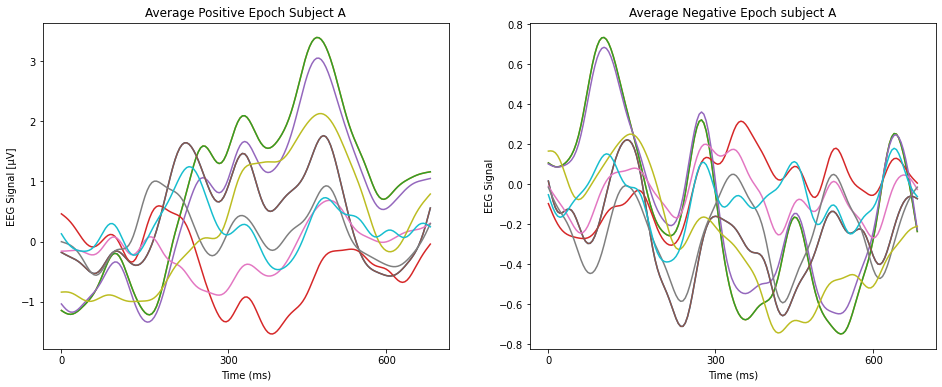

In [8]:
### GRAPH OF THE AVERAGE POSITIVE AND NEGATIVE EPOCHS ###
# Prepare figure
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

idx = np.random.randint(64, size=10)
plt.plot(averagePositiveEpoch[:,idx])
# Set up labels and titles
plt.title(f'Average Positive Epoch Subject {subject}')
plt.xticks([0, 72, 140], ['0', '300', '600'], rotation = 0)
plt.xlabel('Time (ms)')
plt.ylabel('EEG Signal [μV]')

plt.subplot(1,2,2)
plt.plot(averageNegativeEpoch[:,idx])
# Set up labels and titles
plt.title(f'Average Negative Epoch subject {subject}')
plt.xticks([0, 72, 140], ['0', '300', '600'], rotation = 0)
plt.xlabel('Time (ms)')
plt.ylabel('EEG Signal');

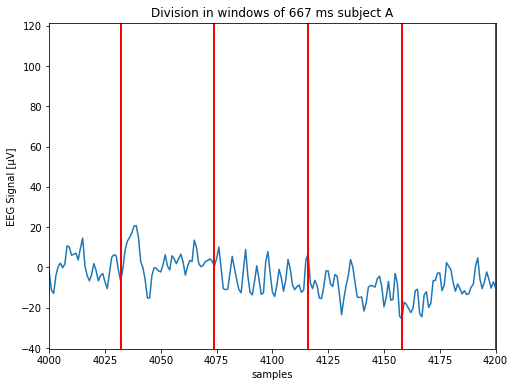

WINDOWS SUBJECT A
the label array is size 25500
the windows of 160 samples are 25500


In [9]:
### PLOT OF SEGMENTED EPOCHS ###
plt.figure(figsize=(8, 6))

plt.plot(np.arange(0,7794), signals[0,:,0])
plt.xlim([4000, 4200])
# plt.ylim([-30, 28])
plt.xlabel('samples')
plt.ylabel('EEG Signal [μV]')
plt.title(f'Division in windows of 667 ms subject {subject}')
xcoords = onset_TRAIN
for xc in xcoords:
    plt.axvline(x=xc, color = 'r')

plt.show()

dim_train=np.array(epochs_TRAIN).shape

print(f'WINDOWS SUBJECT {subject}')
print(f'the label array is size {len(labels_TRAIN)}')
print(f'the windows of 160 samples are {dim_train[0]}')

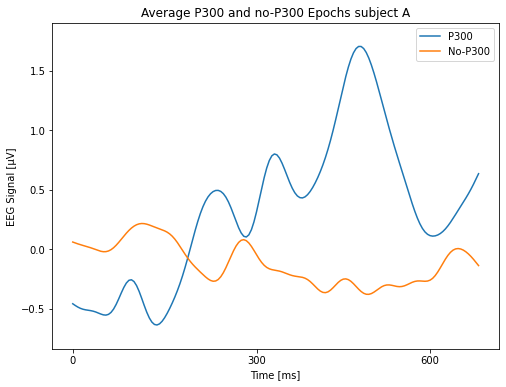

In [10]:
### PLOT AVERAGE P300 AND NO-P300 EPOCHS ###
grandPositiveAverage = np.mean(averagePositiveEpoch, axis = 1)
grandNegativeAverage = np.mean(averageNegativeEpoch, axis = 1)

plt.figure(figsize=(8,6))
plt.plot(grandPositiveAverage)
plt.plot(grandNegativeAverage)
plt.ylim(min(grandPositiveAverage) - 0.2 if min(grandPositiveAverage) < min(grandNegativeAverage) else min(grandNegativeAverage) - 0.2,
         max(grandPositiveAverage) + 0.2 if max(grandPositiveAverage) > max(grandNegativeAverage) else max(grandNegativeAverage) + 0.2)
plt.title(f'Average P300 and no-P300 Epochs subject {subject}')
plt.ylabel('EEG Signal [μV]')
plt.xlabel('Time [ms]')
plt.xticks([0, 72, 140], ['0', '300' ,'600'], rotation=0)
lgd=plt.legend(['P300','No-P300'])

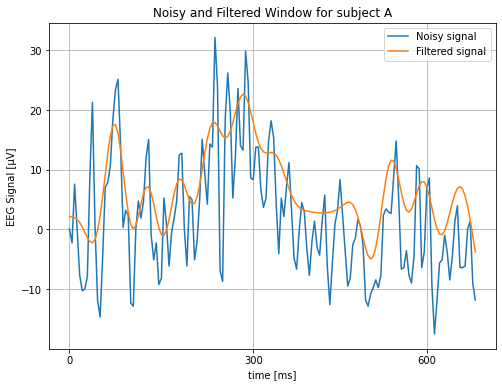

In [11]:
### NOISY AND FILTERED VERSION OF THE SIGNAL ###
plt.figure(figsize = (8,6))
#plt.clf()
plt.plot(signals[0,0:160,0], label= 'Noisy signal')
plt.plot(np.array(epochs_TRAIN)[0,:,0], label= 'Filtered signal')
plt.xlabel('time [ms]')
plt.ylabel('EEG Signal [μV]')
plt.xticks([0, 72, 140], ['0', '300', '600'], rotation = 0)
plt.title(f'Noisy and Filtered Window for subject {subject}')
# plt.hlines([-a, a], 0, max(t), linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best')
#plt.axis([20,30,-0.5e3,0.5e3])

plt.show()

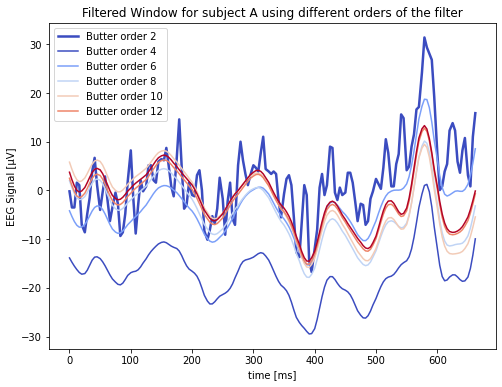

In [12]:
### FILTERED VERSION OF THE SIGNAL USING DIFFERENT ORDERS OF THE FILTER ###

butter_order = [2, 4, 6, 8, 10, 12] # Order of the filter
f_cut_low = 0.1 # Low cut frequency [hz]
f_cut_high = 20 # High cut frequency [hz]
band_type = 'bandpass'
f_s = 240

sos = [] # Initialise array where to store sos values computed from the filter
trial = 40 
channel =50

def plot_butter_filter(butter_order, epoch, f_s, f_cut_low, f_cut_high, band_type):
  filt_epoch = [] # Signal epoch preprocessed using different filters
  for i in range(len(butter_order)): 
      sos.append(signal.butter(butter_order[i], [f_cut_low, f_cut_high], band_type, fs= f_s, output='sos', analog=False))
      
      filt_epoch.append(signal.sosfiltfilt(sos[i], epoch,axis=0)) # Filtering of the epoch

  filt_epoch = np.array(filt_epoch)    

  return filt_epoch

filt_epoch = plot_butter_filter(butter_order, epochs_P300_unF[trial, :,channel], 240, 0.1, 20, 'bandpass')      

# Create figure and add axes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Time values
t = np.arange(0, 666, 1000/240).astype(int)

# Get colors from coolwarm colormap
colors = plt.get_cmap('coolwarm', len(butter_order))

# Plot the signal as baseline
ax.plot(t,epochs_P300_unF[trial, :,channel] , color=colors(0), linewidth=2.5)

# Plot filtered signal 
for i in range(len(butter_order)):
    t = np.arange(0, 666, 1000/240).astype(int)
    y = filt_epoch[i]
    ax.plot(t, y, color=colors(i), linewidth=1.5)

labels = ['Butter order 2', 'Butter order 4', 'Butter order 6', 'Butter order 8', 'Butter order 10', 'Butter order 12']
ax.legend(labels, loc='best');
plt.ylabel('EEG Signal [μV]');
plt.xlabel('time [ms]'); 
plt.title(f'Filtered Window for subject {subject} using different orders of the filter'); 

In [13]:
### EFFECT OF FILTERING ORDER WITH SLIDER ###
rc('animation', html='jshtml') # To enable Slider in Colab 
# I can define a function that provides output given an input provided by widgets 
def signal_filtered(w): 
  trial = 40 
  channel =50
  fig, ax = plt.subplots(figsize=(8,6))
  colors = plt.get_cmap('viridis', 13)
  x = np.arange(0, 666, 1000/240).astype(int)
  y = epochs_P300_unF[trial, :,channel]
  ax.plot(x, y, linewidth=2.5, label = f'Noisy signal')
  sos = signal.butter(w, [f_cut_low, f_cut_high], band_type, fs= f_s, output='sos', analog=False)
  y = signal.sosfiltfilt(sos, epochs_P300_unF[trial, :,channel],axis=0)
  ax.plot(x, y, linewidth=2.0, color=colors(w), label = f'Butter Order {w}')

  # Enable legend
  plt.ylabel('EEG Signal [μV]')
  plt.xlabel('Time [ms]')
  ax.legend()
  ax.set_title(f"Signal Filtering of {trial}-th trial and {channel}-th channel subject {subject}")
  plt.show()

# Here I link the function to the slider
# Description of input widget boundaries : min, max, step.  
widg = widgets.interact(signal_filtered, w=(0.0, 12.0, 1.0))

interactive(children=(FloatSlider(value=6.0, description='w', max=12.0, step=1.0), Output()), _dom_classes=('w…

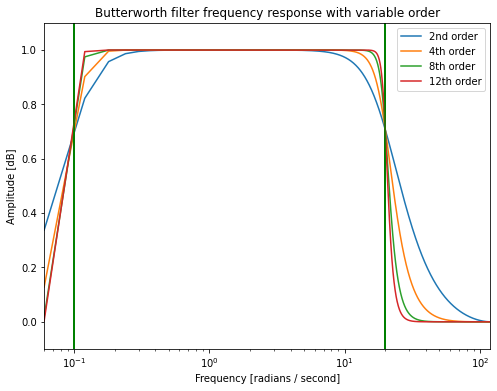

In [14]:
def butter_bandpass(lowcut, highcut, fs, order=5, label=None):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    w, h = signal.sosfreqz(sos,worN=2000)
    plt.semilogx((fs * 0.5 / np.pi) * w, abs(h), label=label)
    plt.title('Butterworth filter frequency response with variable order')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.axvline(0.1, color='green') # cutoff frequency
    plt.axvline(20, color='green') # cutoff frequency
    plt.legend()
    return sos

# Compute the magnitude response for different orders of the model 
fig = plt.figure(figsize=(8, 6))
butter_bandpass(0.1, 20, fs=240, order=2,label ='2nd order')
butter_bandpass(0.1, 20, fs=240, order=4,label ='4th order')
butter_bandpass(0.1, 20, fs=240, order=8,label ='8th order')
butter_bandpass(0.1, 20, fs=240, order=12,label ='12th order')

plt.show()

## Matrix creation 
This step creates a matrix of 64x160 and corresponding labels for training the network. (P300 and no P300)


In [15]:
### CHECK FOR CORRECT DEFINITION OF WINDOWS ###
# REQUIRED FOR MODEL FITTING 
# Negative-positive classes ratio (expected 1.0)
unbalance_ratio = negativeEpochs/positiveEpochs

# 3D Tensor shape expected is (25500, 160, 64)
# The number of time windows is : 15300 (from the original signal: 180x85) + (30x4)x85 (repeat 4 times the P300 windows)
epochs_TRAIN = np.array(epochs_TRAIN)
labels_TRAIN = np.array(labels_TRAIN)
dim_train = epochs_TRAIN.shape

print(f'TRAINING EPOCHS SUBJECT {subject}')
print("Signal windows tensor shape: {}".format(dim_train))
print(f'Unbalance ratio {round(unbalance_ratio, 2)}')

TRAINING EPOCHS SUBJECT A
Signal windows tensor shape: (25500, 160, 64)
Unbalance ratio 1.0


# Model initialisation and fit 
The model proposed by the authors uses 6 layers: 
1. Input and Batch Normalisation
2. 1D spatial filtering 
3. Batch normalisation and 1D spatial filtering (with downsampling)
4. Dense and dropout 
5. Dense and dropout 
6. Sigmoid (2 classes, 1 neuron) 

## Model definition 

In [49]:
### MODEL HYPERPARAMETERS ###
val_split = 0.1
batch_size = 64
number_epochs_TRAIN = len(epochs_TRAIN) # Number of elements inside the training set

lr = 0.001  # learning rate is set to 10^-5 
beta1 = 0.9 # beta_1 parameter for Adam SGD 
beta2 = 0.999 # beta_2 parameter for Adam SGD 
ep = 1e-8 # epsilon parameter for Adam SGD
do = 0.8 # Dropout rate (regularisation technique)

epochs = 8 # Best results are reported when epochs are <8
earlyStopping = False

SEED = 1234

In [50]:
### MODEL SELECTION ###
# Set as True only one at a time
LIU = True
LSTM_CNN = False
CNN1 = False

In [51]:
if LIU: 
  model_name = f'BN3_LIU_{subject}'
  # Model proposed by Liu et al. expected accuracy on test 0.92 in our env.
  input_shape = (None, 160, 64) 
  model = Sequential([
          
          # L0: input + Batch norm
          BatchNormalization(axis=2), 
          
          # L1: Conv 1D Spatial Filter          
          Conv1D(
              filters = 16,
              kernel_size = 1,
              kernel_initializer = tf.keras.initializers.GlorotUniform(seed = SEED),
              activation = 'relu',
              input_shape = (160, 64)
          ),

          # L2: Conv1D + Batch Norm
          BatchNormalization(axis=2),
          
          Conv1D(
              filters = 16,
              kernel_size = 20,
              strides = 20,
              kernel_initializer = tf.keras.initializers.GlorotUniform(seed = SEED),
              activation = 'relu',
          ),
          
          # L3, L4, L5: Classifier
          Flatten(),
          Dense(128, activation='tanh'),
          Dropout(do),

          Dense(128, activation='relu', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = SEED)),
          Dropout(do),

          Dense(1, activation='sigmoid')
      ])

  model.build(input_shape)
  opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1= beta1, beta_2= beta2, epsilon= ep)
  
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  
elif LSTM_CNN: 

  model_name = f'LSTM_CNN_{subject}'

  from keras.engine import Input, Model
  
  eeg_sample_shape = (None, 160, 64)
  #digit_input = Input(shape=eeg_sample_shape)
  #x = Reshape((1, eeg_sample_shape[0], eeg_sample_shape[1]))(digit_input)
 
  model = Sequential([
 
          Conv1D(
              filters = 16,
              kernel_size = 1,
              kernel_initializer = tf.keras.initializers.GlorotUniform(seed = SEED),
              activation = 'relu',
              input_shape = (160, 64)),
          #Permute((2, 1, 1)),
          #x = Reshape((eeg_sample_shape[0], 10))(x)
          LSTM(5, return_sequences=False, implementation=1, dropout=0.5),
          Dropout(0.5),
          Dense(1, activation='sigmoid')
  ])

  model.build(eeg_sample_shape)
  opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1= beta1, beta_2= beta2, epsilon= ep)
  # Unbalanced dataset : possible approach is to give weights to the parameters update
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
elif CNN1: 
  model_name = f'CNN_{subject}'
  input_shape = (None, 160, 64)
  model = Sequential([
        Conv1D(
            filters = 10,
            kernel_size = 1,
            padding = "same",
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed = SEED),
            use_bias = True,
            activation = 'relu',
            input_shape = (160, 64)
        ),
        Conv1D(
            filters = 20,
            kernel_size = 13,
            padding = "valid",
            strides = 11,
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed = SEED),
            use_bias = True,
            activation = 'relu',
        ),
        Flatten(),
        Dense(100, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    
  model.build(input_shape)
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 160, 10)           650       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 14, 20)            2620      
_________________________________________________________________
flatten_6 (Flatten)          (None, 280)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               28100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 31,471
Trainable params: 31,471
Non-trainable params: 0
__________________________________________________

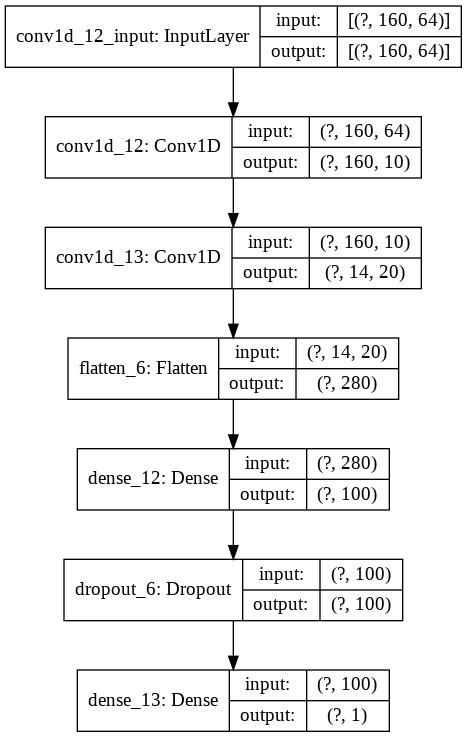

In [52]:
### PLOT MODEL ARCHITECTURE ### 
keras.utils.plot_model( 
    model,
    to_file=f'model_{model_name}.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB', # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
)

## Tensorboard and model checkpoints

In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime, os

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
#%load_ext tensorboard
#%tensorboard --logdir '/content/gdrive/My Drive/Project/classification_experiments' --port 6009

In [53]:
### CALLBACKS ###
# 1. MODEL CHECKPOINTS
# 2. TENSORBOARD 
# 3. EARLY STOPPING 

import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join('/content/gdrive/My Drive/Project/', 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
if earlyStopping:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    callbacks.append(es_callback)

## Model FIT 


In [54]:
history = model.fit(
    x = epochs_TRAIN,  
    y = labels_TRAIN,
    # Steps are proportional to the val_split
    steps_per_epoch= np.ceil((1-val_split)*((number_epochs_TRAIN)/ batch_size)), 
    epochs= epochs,
    validation_split = val_split, 
    # Steps are proportional to the val_split
    validation_steps = np.ceil(val_split*((number_epochs_TRAIN)/ batch_size)),
    callbacks= callbacks, 
    shuffle = 1, 
)

model.save(f'{model_name}.h5')

Epoch 1/8
359/359 [==============================] - 3s 9ms/step - loss: 0.7942 - accuracy: 0.5329 - val_loss: 0.6989 - val_accuracy: 0.5110
Epoch 2/8
359/359 [==============================] - 3s 8ms/step - loss: 0.6703 - accuracy: 0.5886 - val_loss: 0.7100 - val_accuracy: 0.5376
Epoch 3/8
359/359 [==============================] - 3s 8ms/step - loss: 0.6371 - accuracy: 0.6360 - val_loss: 0.7195 - val_accuracy: 0.5235
Epoch 4/8
359/359 [==============================] - 3s 8ms/step - loss: 0.5825 - accuracy: 0.6861 - val_loss: 0.7666 - val_accuracy: 0.5620
Epoch 5/8
359/359 [==============================] - 3s 8ms/step - loss: 0.5270 - accuracy: 0.7388 - val_loss: 0.8330 - val_accuracy: 0.5659
Epoch 6/8
359/359 [==============================] - 3s 8ms/step - loss: 0.4390 - accuracy: 0.7938 - val_loss: 0.9402 - val_accuracy: 0.5647
Epoch 7/8
359/359 [==============================] - 3s 9ms/step - loss: 0.3669 - accuracy: 0.8406 - val_loss: 1.1310 - val_accuracy: 0.5388
Epoch 8/8
359

## Model evaluation 
Evaluate the performance of the model over the train set vs. the validation set 

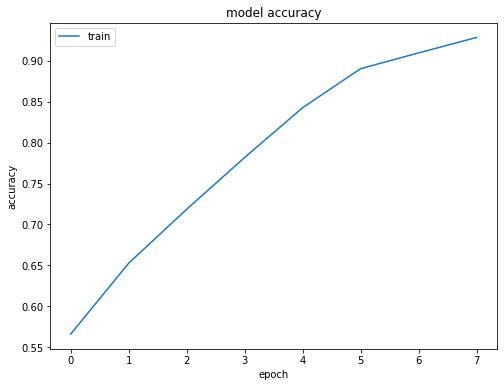

In [22]:
### PLOT TRAINING ACCURACY DURING EACH EPOCH ###
fig2 = plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])

if val_split != 0:
  plt.plot(history.history['val_accuracy'])
  
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
lgd = plt.legend(['train', 'validation'], loc='best')
plt.grid(False)

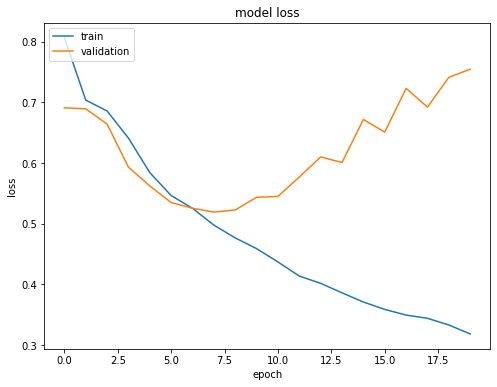

In [ ]:
### PLOT TRAINING LOSS DURING EACH EPOCH ###
fig2 = plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])

if val_split != 0:
  plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
lgd = plt.legend(['train', 'validation'], loc='upper left')

# Model prediction

In [ ]:
### IMPORT MODEL FROM DIRECTORY ### 
#@title Import Model From Directory 
#@markdown Select the model to use for prediction on the test set
subject = "A" #@param ["A", "B"]
model_to_use = "BEST_BN3_LIU_A" #@param ["BEST_BN3_LIU_A", "BN3_LIU_A", "BN3_LIU_B", "LSTM_CNN_A", "LSTM_CNN_B", "CNN_A", "CNN_B", "BEST_BN3_LIU_B"]


model = keras.models.load_model(f'/content/gdrive/My Drive/Project/{model_to_use}.h5')

In [ ]:
### IMPORT THE TEST SET DEPEDING ON THE SUBJECT ###
data_TEST = loadmat(test_dir) 
f_s = 240
# The variables inside the file are arrays: 
signals_TEST = data_TEST['Signal'] # (100, 7794, 64)
flashing_TEST = data_TEST['Flashing']
stimulus_code_TEST = data_TEST['StimulusCode']

# Compute the duration of the recording = (100 * 7794) / (240 Hz * 60) [min]
samples_TEST = len(signals_TEST[0])
signal_duration_TEST = (len(signals_TEST))*(samples_TEST)/(f_s*60)
# Compute number of trials
trials_TEST = len(stimulus_code_TEST)

print(f"TEST INFO SUBJECT {subject}")
print("Fs: %d Hz [%.2f ms]" % (f_s, (1000/f_s)))
print("signal duration:   %.2f min" % signal_duration_TEST)
print("letters to predict:  %d" % trials_TEST )

TEST INFO SUBJECT B
Fs: 240 Hz [4.17 ms]
signal duration:   54.12 min
letters to predict:  100


## Preprocessing on the test set 

In [ ]:
### FILTERING AND WINDOWING OF THE SIGNAL ###
num_channels = len(CHANNELS) # Number of EEG channels

epochs_TEST = []     # Init 3D array to store EEG epochs of the test set
onset_TEST = []      # Init array of onset stimulus 

# window_length = 667 ms after stimulus onset 
epochDuration = round(f_s*0.667)  # Duration of th epoch is 667 ms

############# BUTTERWORTH FILTER ###############
butter_order = 8 # Order of the filter
f_cut_low = 0.1 # Low cut frequency [hz]
f_cut_high = 20 # High cut frequency [hz]
band_type = 'bandpass'

sos = signal.butter(butter_order, [f_cut_low, f_cut_high], 
                    band_type, fs= f_s, output='sos', analog=False)


for trial in tqdm(range(trials_TEST), desc='Trials Test'): 
  for sample in range(samples_TEST):
    # Check if flashing changed from 0 or 1 or if it's the first sample 
    if ( sample == 0 or (flashing_TEST[trial, sample-1] == 0 and flashing_TEST[trial, sample] == 1)):
      lower_sample = sample # fist sample of the epoch
      onset_TEST.append(sample)
      upper_sample = sample + epochDuration # last sample of the epoch
      epoch = signals_TEST[trial, int(lower_sample):int(upper_sample), :] # epoch is composed of all 64 channels
      
      epoch = signal.sosfiltfilt(sos, epoch,axis=0) # Filtering of the epoch
      epochs_TEST.append(epoch) # Epoch filtered is added to the array of epochs 

In [ ]:
import gc
gc.collect()

0

In [ ]:
## From this code we obtain epochs_TEST 
epochs_TEST = np.array(epochs_TEST)
dim_test = epochs_TEST.shape # expected dims are (18000, 160, 64)

print(f'TEST SUBJECT {subject}')
print("Signal windows tensor shape: {}".format(dim_test))

TEST SUBJECT B
Signal windows tensor shape: (18000, 160, 64)


## Function definition for prediction  

Here are defined some important functions: 
-  Create the expected stimulus code on the test set 
- Compute the binary prediction
- Calculate the metrics of the P300 detection model

Modified version of the code 
Credits: https://github.com/CaprioloSaggio/P300_Speller/blob/master/AY1920_DT_P300_SPELLER_02.ipynb

In [ ]:
### REMOVAL OF REDUNDANCY FROM STIMULUS CODE TEST ###
# TODO: We can decide to move this code inside the for loop over trials and samples 
def stimulusCode_reduced(stimCode):
  newStimCode = []
  for i in range(len(stimCode[:,0])): # iterate for all the trials (letters) in the subject session
    index = np.where(np.diff(stimCode[i]) == 0) # find indeces where stimulus' codes repeat in the same trial (finding one letter) (1,1,1,1,1,0,0,0,0,7,7,7,7,0,0,0,0,12,12,12,12,0,0,0,0,...)
    newTemp_stimcode = np.delete(stimCode[i], index) # delete multiple sequence of the same number, keeping only the stimulus's codes interleaved by a zero (1, 0, 7, 0, 12, 0, ...)
    index = np.where(newTemp_stimcode == 0) # find indeces where zeros are
    newTemp_stimcode = np.delete(newTemp_stimcode, index) # delete zeros in the sequence (1, 7, 12, ...)
    newStimCode.append(newTemp_stimcode) # storing the reduced stimulus' code for each trials

  return np.array(newStimCode) # returning the session stimulus'code

In [ ]:
##### TRANSFORM TARGET CHARS INTO TEST STIMULUS TYPE ARRAY #####
def target_test(stimulusCode_TEST, wordTEST):
  
  # experimental grid
  MA = [['A','B','C','D','E','F'],
        ['G','H','I','J','K','L'],
        ['M','N','O','P','Q','R'],
        ['S','T','U','V','W','X'],
        ['Y','Z','1','2','3','4'],
        ['5','6','7','8','9','_']]
  
  MA_array = np.array(MA)

  # stimCode is used in its reduced version
  stimulus_code_reduced = stimulusCode_reduced(stimulusCode_TEST) # reduce dimension of stimulus code

  target_TEST = []
  
  for k in range(len(wordTEST)): # for every line/letter in the test set 
    i = np.where(MA_array == wordTEST[k])[0][0] + 7 
    j = np.where(MA_array == wordTEST[k])[1][0] + 1
    for sample in range(180): # every time I find a number of columns in stimulusCode corresponding to the letter spelled by the subject
      if (stimulusCode_TEST[k][sample] == i or stimulusCode_TEST[k][sample] == j): # check if the column or the row is the target one
        target_TEST.append(1)
      else:
        target_TEST.append(0)

  return np.array(target_TEST)

In [ ]:
def pred_to_binary(preds,th):
  ###### DESCRIPTION pred_to_binary ######
  # This function converts the prediction in binary form. 
  ##### INPUTS ######
  # preds: predictions obtained after model.predict 
  # th: threshold to recognise P300 or no P300 

  ##### BODY #####
  # Initialise array for the predictions
  binary_predictions=np.zeros(len(preds))

  # Range over all predictions and set them to either 0 or 1
  for i in range(len(preds)):
    if preds[i] < th:
      binary_predictions[i] = 0
    else:
      binary_predictions[i] = 1

  # Return the array of binary predictions
  return binary_predictions

In [ ]:
def metrics (target_test, preds):
  cm = confusion_matrix(target_test, preds)
  TN = cm[0,0]
  FP = cm[0,1]
  FN = cm[1,0]
  TP = cm[1,1]
  P = TP + FN
  N = TN + FP

  # sensitivity = TP / (TP + FN)
  sensitivity = recall_score(target_test, preds)
  print (f'sensitivity on test subject {subject} : {sensitivity}')

  specificity = TN / (TN + FP)
  print (f'specificity on test {subject}' ':\n',specificity)

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  print (f'accuracy on test {subject}: {accuracy}')

  # PPV = TP / (TP + FP)
  PPV = precision_score(target_test, preds)
  print (f'PPV on test {subject} : {PPV}')

  NPV = TN / (TN + FN) # Negative predictive value
  print (f'NPV on test {subject}: {NPV}')

  import sklearn.metrics as metrics
  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(target_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  # method I: plt
  plt.figure(figsize=(8,6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

## Load Target test data 

In [ ]:
#### LOAD TEST TARGET CHARS #### 
target_char = loadmat('/content/gdrive/My Drive/Project/Data/TestTargetChars.mat')

target_char = target_char[f'{subject}_TargetChar'] 
target_char = list(target_char[0])

In [ ]:
#### TARGET TEST is stimulus type for test ####

target_TEST = target_test(stimulus_code_TEST, target_char)

print(f'TEST SUBJECT {subject}')
print("Target test shape: {}".format(target_TEST.shape))
print("Target test unique values: {}".format(np.unique(target_TEST)))

TEST SUBJECT B
Target test shape: (18000,)
Target test unique values: [0 1]


## Prediction on the test set 

In [ ]:
### MODEL PREDICT ### 

print(f'PREDICTION ON SUBJECT {subject} USING {model_to_use}')
predictions = model.predict(epochs_TEST)
binary_preds = pred_to_binary(predictions, 0.5)


PREDICTION ON SUBJECT B USING BEST_BN3_LIU_B


## Metrics and ROC curve of predicted P300 events

sensitivity on test subject B : 0.29662698412698413
specificity on test B:
 0.7064564564564565
accuracy on test B: 0.6605555555555556
PPV on test B : 0.11304347826086956
NPV on test B: 0.8884343036978757


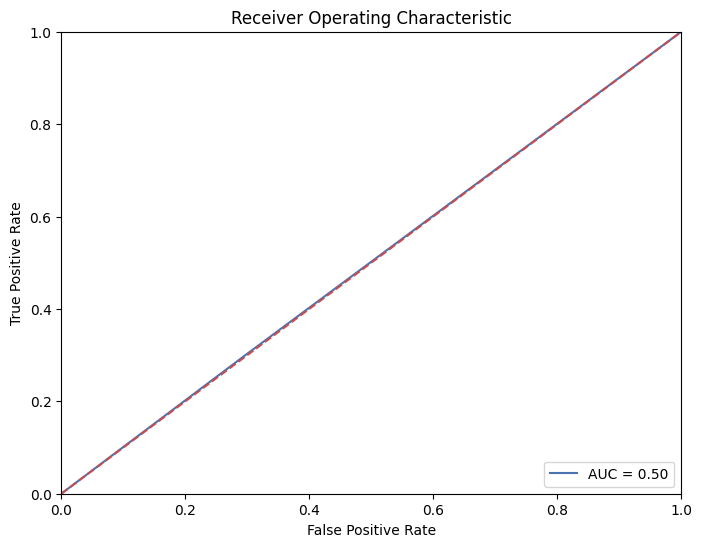

In [ ]:
metrics(target_TEST, binary_preds)

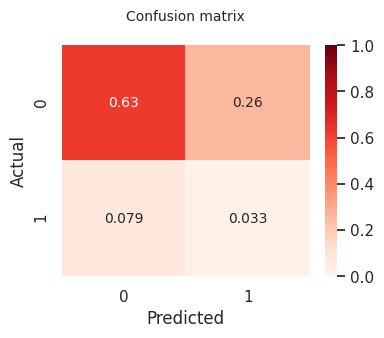

In [ ]:
### CONFUSION MATRIX ### 
data = confusion_matrix(y_true=target_TEST, y_pred=binary_preds)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(target_TEST))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(target_TEST), index = np.unique(target_TEST))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3))
sns.set(font_scale = 1.0)
cm = sns.heatmap(df_cm, cmap="Reds", annot=True, annot_kws = {"size": 10}, vmin=0, vmax=1)
cm.axes.set_title("Confusion matrix\n", fontsize=10)
plt.show()

# P300 SPELLER 

## Speller Function definition 
Here are defined some important functions: 
-  From row + col index to letter of the speller 
- From letter to row + col index 
- Calculate predictions of the letter from P300 detection and the metrics of the Speller 

Modified version of the code 
Credits: https://github.com/CaprioloSaggio/P300_Speller/blob/master/AY1920_DT_P300_SPELLER_02.ipynb

In [ ]:
def index2letter(r,c):
    ###### DESCRIPTION index2letter ######
    # Transforms the coded version of row and column intensification to the correposponding char

    ##### INPUTS #####
    # r : row value (7,12)
    # c : column value (1,6)
    
  ##### BODY FUNCTION #####
  # Sort the input so that it is row, column
  temp=[r,c]
  temp.sort()
  r=temp[0]
  c=temp[1]
 
  MA=[['A','B','C','D','E','F'],
    ['G','H','I','J','K','L'],
    ['M','N','O','P','Q','R'],
    ['S','T','U','V','W','X'],
    ['Y','Z','1','2','3','4'],
    ['5','6','7','8','9','_']]
  
  i=c-7
  j=r-1
 
  letter=MA[i][j]
  return letter

def letter2index(word):
  ###### DESCRIPTION char2rc ######
  # Transforms the char into the corresponding row, column intensification
  
  ##### INPUTS ######
  # char: character of the board
  
  ##### BODY FUNCTION #####
  # Define the matrix presented to the subject
  MA=[['A','B','C','D','E','F'],
    ['G','H','I','J','K','L'],
    ['M','N','O','P','Q','R'],
    ['S','T','U','V','W','X'],
    ['Y','Z','1','2','3','4'],
    ['5','6','7','8','9','_']]
  
  temp_MA = np.array(MA)

  r = np.where(temp_MA==(word))[0][0] + 7
  c = np.where(temp_MA==(word))[1][0] + 1
  
  return r,c

In [ ]:
def speller(predictions, stimulus_code, word, repetitions=15):

  intensifications = 12 # A single letter acquisition is made of 12 intensifications
  y_pred = np.reshape(predictions, (-1,180)) # Reshape 1D array into a 100x180 matrix
  prediction = np.zeros((len(word), intensifications)) # Size is (number of letters x intensifications = (100x12)). Stores the cumulative sum of predictions corresponding to increasing number of repetitions over time for all the letters
  accuracy = np.zeros(repetitions) # 15 for the 15 repetitions
  accuracy_letter = np.zeros(repetitions) # 15 for the 15 repetitions

  for rep in range (0, repetitions*intensifications, intensifications): # Repeat 15 times with step of 12 samples (intensifications) : from 0 to 179 with step = 12
    correct_letters = 0 # Temporary variable to store the number of correct letter classification in one repetition
    correct_classifications = 0 # Temporary variable to store the number of correct classification (P300 or not) in one repetition
    final_word = []

    for letter in range(y_pred.shape[0]): # looping in whole dataset letters : from 0 to 99
      temp_pred = y_pred[letter, rep : rep + 12] # extract a single repetion for a single letter
      stimulus_code_temp = stimulus_code[letter, rep : rep + 12].astype('int32') # extract the corresponding stimulus code for the extracted repetition
      prediction[letter] += temp_pred[stimulus_code_temp.argsort()] # Sort the prediction according to its stimulus code, so I end up with an array in which at the first place I have
      # the cumulative probability to find a P300 at the given point of the session, taking into account all the past repetitions
      # stimulus_code_temp.argsort() returns the indeces that i need to order my stimulus code inside the repetition in order to have [1,2,3,4,5,6,7,8,9,10,11,12]
      r = np.argmax(prediction[letter,6:12]) + 7 # From 7 to 12 we have the rows
      c = np.argmax(prediction[letter,0:6]) + 1 # From 1 to 6 we have the columns
      target_letter = index2letter(r,c) # Find correspondant letter
      final_word.append(target_letter) # Put the letter into the result
      if word[letter] == target_letter:
        correct_letters += 1
      r_temp, c_temp = letter2index(word[letter]) # Getting the stimulus code for the letter I'm considering
      if r == r_temp: # Check if the stimulus code is the same for rows
        correct_classifications += 1 # Then I properly classify my epoch
      if c == c_temp: # Check if the stimulus code is the same for columns
        correct_classifications += 1 # Then I properly classify my epoch
  
  # Compute accuracy with a resolution of rows-and-columns and of letters
  # I divided by len(word)*2 because for each letter I need to classify properly one row and one column
    accuracy[int(rep/intensifications)] = correct_classifications / (len(word)*2) 
    accuracy_letter[int(rep/intensifications)] = correct_letters / len(word)

   
  # Print results
  print("RESULTS")
  for i in range(10): 
    print("final word: ", str(final_word[i:i+10]))
    print("real word: ", str(word[i:i+10]))
  
  return final_word, accuracy, accuracy_letter

## Letter classification 

In [ ]:
#### REDUCE THE STIMULUS CODE AND FORMAT TARGET CHARS ####
stimulus_code_target = stimulusCode_reduced(stimulus_code_TEST)
target_word = target_char

In [ ]:
# reshaping 
y_pred = np.reshape(predictions, (-1,180))
predictions.shape

(18000, 1)

In [ ]:
target_word_out, accuracy, accuracy_letter = speller(predictions, stimulus_code_target, target_word)

RESULTS
final word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U']
real word:  ['M', 'E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U']
final word:  ['E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'Z']
real word:  ['E', 'R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H']
final word:  ['R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'Z', 'J']
real word:  ['R', 'M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J']
final word:  ['M', 'I', 'R', 'O', 'O', 'M', 'U', 'Z', 'J', 'P']
real word:  ['M', 'I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P']
final word:  ['I', 'R', 'O', 'O', 'M', 'U', 'Z', 'J', 'P', 'X']
real word:  ['I', 'R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X']
final word:  ['R', 'O', 'O', 'M', 'U', 'Z', 'J', 'P', 'X', 'J']
real word:  ['R', 'O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J']
final word:  ['O', 'O', 'M', 'U', 'Z', 'J', 'P', 'X', 'J', 'O']
real word:  ['O', 'O', 'M', 'U', 'H', 'J', 'P', 'X', 'J', 'O']
final word:  ['O', 'M', 'U', 'Z', 'J', 'P', 'X', 'J', 'O', 'H']
real word:  ['O', 'M', 'U', 'H', 'J', '

In [ ]:
print(f'Accuracy of letter classification Subject {subject} with model {model_to_use}')
columns=['1','2','3','4','5','6','7','8','9','10','11','12', '13', '14', '15']
a = np.array(accuracy_letter)
a = a.reshape(-1, len(a))
pd.DataFrame(a,columns=columns)

Accuracy of letter classification Subject B with model BEST_BN3_LIU_B


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.31,0.5,0.6,0.63,0.7,0.77,0.81,0.81,0.89,0.87,0.88,0.88,0.88,0.89,0.91


In [ ]:
print(f"Accuracy of rows and columns classification Subject  {subject} with model {model_to_use}")
b = np.array(accuracy)
b = b.reshape(-1, len(b))
pd.DataFrame(b,columns=columns)

Accuracy of rows and columns classification Subject  B with model BEST_BN3_LIU_B


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.565,0.695,0.76,0.785,0.83,0.87,0.895,0.9,0.945,0.935,0.94,0.94,0.935,0.94,0.955


## Plot Accuracy in function of repetitions

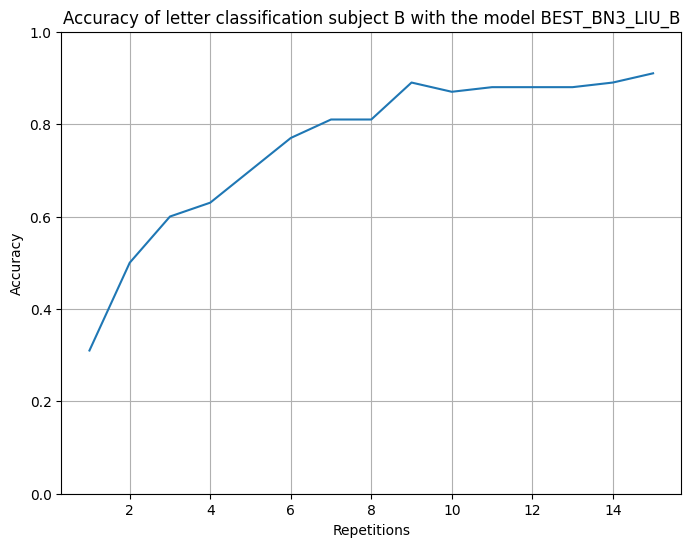

In [ ]:
# Need to reset the rcParams to default since we used seaborn before. 
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

fig = plt.figure(figsize=(8,6))
plt.grid(True)
plt.ylim(0, 1) # set the vertical range to [0-1]
t = range(1,16)
plt.plot(t, accuracy_letter)
plt.xlabel('Repetitions')
plt.ylabel('Accuracy')
plt.title(f'Accuracy of letter classification subject {subject} with the model {model_to_use}')

fig.savefig('accuracy.png')

# Electrodes evaluation  

## Spatial visualization of evoked potentials

In [ ]:
#transform from 3d data to 4d data 

def matrixchannel(epoch):

  m = np.zeros((len(epoch[:,0,0]),len(epoch[0,:,0]),10,11))
  
  m[:,:,0,4:7]=epoch[:,:,21:24] #from Fp1 to Fp2
  m[:,:,1,3:8]=epoch[:,:,24:29] #from Af7 to Af8
  m[:,:,2,1:10]=epoch[:,:,29:38] #from F7 to F8
  m[:,:,3,1]=epoch[:,:,38] #Ft7
  m[:,:,3,2:9]=epoch[:,:,0:7] #from FC5 to FC6 
  m[:,:,3,9]=epoch[:,:,39] #Ft8
  m[:,:,4,1]=epoch[:,:,40] #T7
  m[:,:,4,2:9]=epoch[:,:,7:14] #from C5 to C6
  m[:,:,4,9]=epoch[:,:,41] #T8
  m[:,:,5,1]=epoch[:,:,44] #Tp7
  m[:,:,5,2:9]=epoch[:,:,14:21] #from Cp5 to Cp6
  m[:,:,5,9]=epoch[:,:,45] #Tp8
  m[:,:,4,0]=epoch[:,:,42] #P9 (auditory) T9 (visual)
  m[:,:,6,1:10]=epoch[:,:,46:55] #from P7 to P8 
  m[:,:,4,10]=epoch[:,:,43] #P10 (auditory) T10 (visual)
  m[:,:,7,3:8]=epoch[:,:,55:60] #from PO7 to PO8
  m[:,:,8,4:7]=epoch[:,:,60:63] #from O1 to O2 
  m[:,:,9,5]=epoch[:,:,63] #Iz 

  return m # m is a 10-by-11 matrix containing the epochs corresponding to each electrode

In [ ]:
# reshaping into a matrix 
epochs_P300_reshaped = matrixchannel(epochs_P300)
epochs_noP300_reshaped = matrixchannel(epochs_noP300)

print(epochs_P300_reshaped.shape) # print the dimensions obtained

(2550, 160, 10, 11)


In [ ]:
epochs_P300_mean = np.mean(epochs_P300_reshaped, axis=0)
epochs_noP300_mean = np.mean(epochs_noP300_reshaped, 0)
epochs_P300_mean.shape

(160, 10, 11)

### P300 graph 

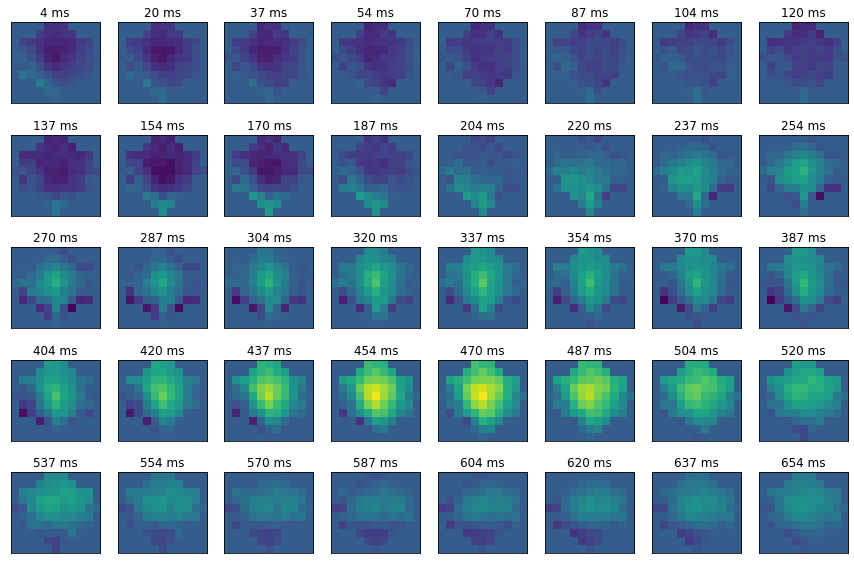

In [ ]:
num=15 # select the 11th epoch as a random demonstrative example
maxi=epochs_P300_mean[:].ravel().max() # For the plotting range
mini=epochs_P300_mean[:].ravel().min() # For the plotting range
k=0
plt.figure(figsize=(15,10))
for i in range(0,160,4):
  plt.subplot(5,8,k+1)
  plt.imshow(epochs_P300_mean[i],  vmin=mini, vmax=maxi, cmap='viridis') 
  plt.title(   str( int((i+1)/240*   1000) ) + " ms"   )
  # plt.colorbar()
  plt.xticks([])
  plt.yticks([])
  k=k+1

### noP300 graph 

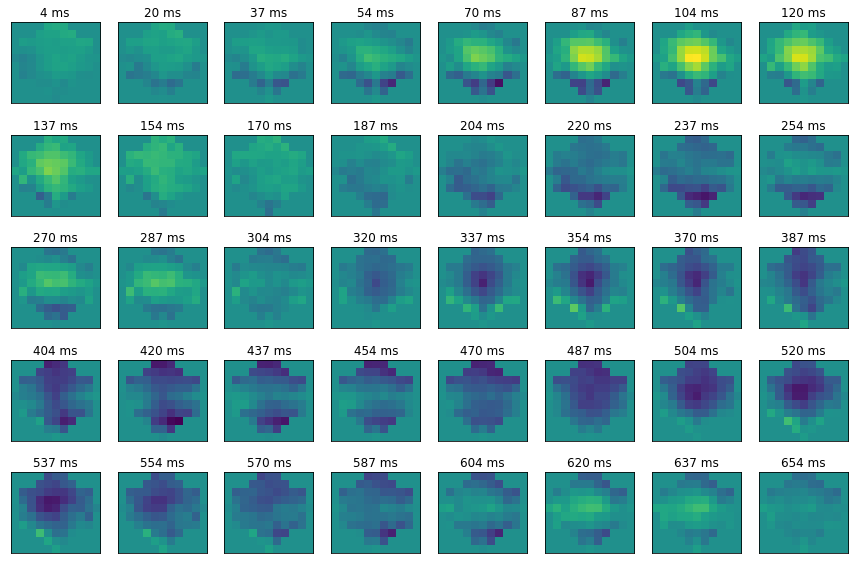

In [ ]:
maxi=epochs_noP300_mean[:].ravel().max() # For the plotting range
mini=epochs_noP300_mean[:].ravel().min() # For the plotting range
k=0
plt.figure(figsize=(15,10))
for i in range(0,160,4):
  plt.subplot(5,8,k+1)
  plt.imshow(epochs_noP300_mean[i],  vmin=mini, vmax=maxi, cmap = 'viridis') 
  plt.title(   str( int((i+1)/240*   1000) ) + " ms"   )
  #plt.colorbar()
  plt.xticks([])
  plt.yticks([])
  k=k+1

## Feature Maps Visualization

## First convolutional layer output average




In [ ]:
model = keras.models.load_model(f'/content/gdrive/My Drive/Project/{model_to_use}.h5')

NameError: ignored

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:6]] 
# Extracts the outputs of the top 6 layers

activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input
test_array=np.array(epochs_P300)
tensor = test_array

activations = activation_model.predict(tensor) 
# Returns a list of five Numpy arrays: one array per layer activation
firstConvLayer_activation = activations[1]

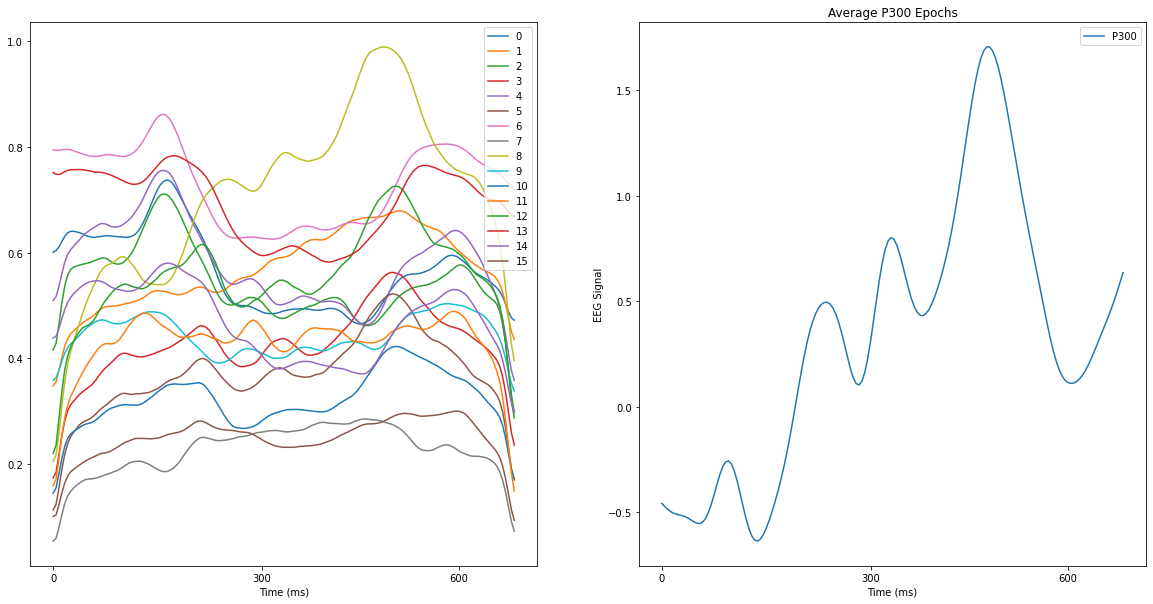

In [ ]:
### AVREAGE EPOCHS FEATURE MAPS 
AVG_firstConvLayer_activation=np.mean(firstConvLayer_activation,axis=0)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
for i in range(16):
  plt.plot(AVG_firstConvLayer_activation[:,i])
plt.xlabel('Time (ms)')
plt.xticks([0, 72, 140], ['0', '300' ,'600'], rotation=0)
lgd=plt.legend(range(16))

plt.subplot(1,2,2)
grandPositiveAverage = np.mean(averagePositiveEpoch, axis = 1)

plt.plot(grandPositiveAverage)
plt.title('Average P300 Epochs')
plt.ylabel('EEG Signal')
plt.xlabel('Time (ms)')
plt.xticks([0, 72, 140], ['0', '300' ,'600'], rotation=0)
lgd=plt.legend(['P300'])

## Visualising weights of first conv. layer

In [ ]:
second_layer_weights = model.layers[1].get_weights()[0]

model_weights=np.array(second_layer_weights)
model_weights = np.transpose(model_weights, (0, 2, 1))
model_weights.shape

(1, 16, 64)

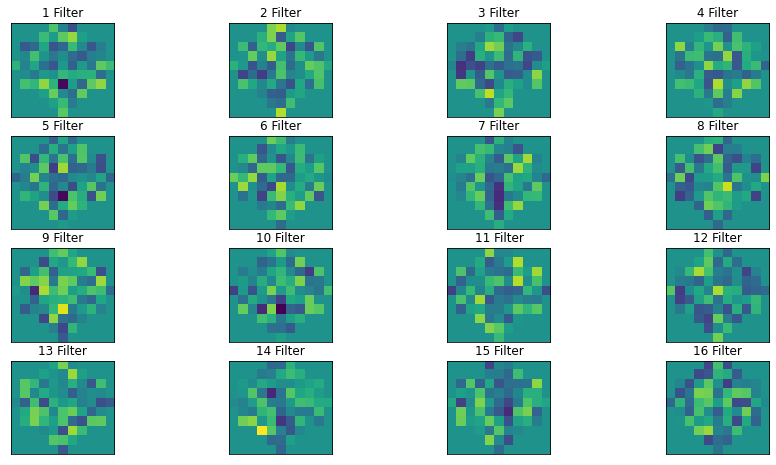

In [ ]:
fig_weights = matrixchannel(model_weights)

maxi=model_weights[:].ravel().max() # For the plotting range
mini=model_weights[:].ravel().min() # For the plotting range
k=0

plt.figure(figsize=(15,10))
for i in range(16):
  plt.subplot(5,4,k+1)
  
  plt.imshow(fig_weights[0,i, :, :],  vmin=mini, vmax=maxi, cmap='viridis') 
  plt.title(   str( int(i+1) )+ " Filter"   )
  # plt.colorbar()
  plt.xticks([])
  plt.yticks([])
  k=k+1

In [ ]:
### PLOT FILTER NUMBER, RANKING AND NAME OF THE ELECTRODE ### 
# for i in range(16): 
  # for j in range(4): 
    # print(f'Idx {i+1}-th filter, {j+1}-th highest is : {str(idx[i][j])} and the CH name is {CHANNELS[idx[i][j]]}')

In [ ]:
#CHANNEL
CHANNEL_LOCATIONS_FILE_PATH = os.path.join(data_dir, 'channels.csv')
ELOC64_BCI_DATASETII = 'eloc64.txt'

In [ ]:
### PLOT OF THE ELECTRODES ###
### Credits to topolot.m from Dataset II 
### The function has been changed to serve the need of plotting relevant electrodes
### The function can handle only a specific type of txt file. (4 columns) 
### TXT structure : index, theta value, rho value, electrode name (dots are used to delimit)

def plot_electrodes(channel_file_dir, eloc_dir, electrode_list): 
  #### DEPENDENCIES 
  # numpy, pandas, matplotlib 
  #### INPUTS
  # channel_file_dir : path to the channels.csv file with channel names
  # eloc_dir : directory where is placed the eloc file (.txt format expected)
  # electrode_list : lists of electorde indices from 0 to 63. No need to be ordered
  #### OUTPUTS
  # output : plot of the electrode positions in the 2D domain 
  #### EXAMPLE OF USAGE 
  # plot_electrodes(CHANNEL_LOCATIONS_FILE_PATH, ELOC64_BCI_DATASETII, [0, 10, 32, 18, 16])

  #### BODY FUNCTION 
  ## STEP 1: import channel names from file channels.csv 
  CHANNELS = []
  # Read file content
  with open(channel_file_dir, "r") as f:
    file_content = f.read()
    # Loop over all rows (except first one)
    for row in file_content.split("\n")[1:]: 
      # Skip missing rows
      if row == '':
        continue
      CHANNELS.append(row)
  
  ## STEP 2: scan file with electrode positions (in polar coordinates)
  loc_pos = np.genfromtxt(eloc_dir, delimiter='\t', 
                          dtype=('U10','U10',float,float)).tolist()
  df = pd.DataFrame(loc_pos,    #transform in pd.dataframe 
                    columns=['idx', 'theta', 'rho', 'electrode_name'])
  
  ## STEP 3: transform dataframe and append electorde names
  df['idx'] = pd.to_numeric(df['idx'], downcast="float")
  df['theta'] = pd.to_numeric(df['theta'], downcast="float")
  df['rho'] = pd.to_numeric(df['rho'], downcast="float")
  df['electrode_name'] = CHANNELS # channels range from 0 to 63
  df = df.round(3) # round the float

  ## STEP 4: Position of the ears to be plotted (derived from topoplotEEG.m)
  EarX = np.array([0.497, 0.51, 0.518, 0.5299, 0.5419, 0.54, 0.547, 0.532, 0.51, 0.489])
  EarY = np.array([0.0555, 0.0775, 0.0783, 0.0746, 0.0555, -0.0055, -0.0932, -0.1313, -0.1384, -0.1199])
  rmax = 0.5 # plot boundaries 
  ## STEP 5: define rho and theta for all the electrodes
  Th = (np.pi/180)*df['theta']  # convert degrees to radians
  Rd = df['rho']
  # convert into np array since it is less prone to errors
  Th = np.array(Th)
  Rd = np.array(Rd)
  ## STEP 6: transform electored_list in array
  result_vector = np.array(electrode_list)
  ## STEP 7: define rho and theta for result_vector indices
  Th_my = (np.pi/180)*df.iloc[result_vector, 1]   # convert degrees to radians
  Rd_my = df.iloc[result_vector, 2]
  Th_my = np.array(Th_my)
  Rd_my = np.array(Rd_my) # convert into np array since it is less prone to errors

  ## STEP 8: transform theta and rho values in x, y coordinates 
  # Initialise lists 
  x = [] # variables used to plot electrode position
  y = [] # variables used to plot electrode position 

  my_x = [] # variables used to plot relevant electrodes
  my_y = [] # variables used to plot relevant electrodes 

  # transform from polar to cartesian coordinates
  for k in range(len(Th_my)): 
    my_x.append(Rd_my[k] * np.cos(Th_my[k])) # rho * cos(theta)
    my_y.append(Rd_my[k] * np.sin(Th_my[k])) # rho * sin(theta)

  for i in range(len(Th)): 
    x.append(Rd[i] * np.cos(Th[i])) # rho * cos(theta)
    y.append(Rd[i] * np.sin(Th[i])) # rho * sin(theta)
  
  ## STEP 9: plot the head 
  ha = plt.gca()
  plt.cla()
  # rmax = 0.5 (already defined before)

  ha.set_xlim(-rmax*1.3, rmax*1.3)
  ha.set_xlim(-rmax*1.3, rmax*1.3)

  #### Draw Head ####
  l = np.arange(0, 2*np.pi, 2*np.pi/100)
  basex = 0.18*rmax  
  tip = rmax*1.15
  base = rmax-0.004

  # Plot Electrodes 
  sc = ha.scatter(y,x)
  my = ha.scatter(my_y,my_x,c= 'r', linewidth = 7)

  # Plot Head, Ears, Nose
  head = ha.plot(np.cos(l)*rmax,np.sin(l)*rmax,'-',c = 'k' ,linewidth=2)
  Nose = ha.plot([0.18*rmax,0,-.18*rmax],[base,tip,base],c = 'k', linewidth=2)
  ear = ha.plot(EarX,EarY, c = 'k' )
  ear = ha.plot(-EarX,EarY,linewidth=2, c = 'k')   
  ha.axis('off')

In [ ]:
### EXTRACTION OF FOUR MOST IMPORTANT ELECTORDES PER FILTER ###
filter_weights = []
idx = []

for i in range(16): 
  arr = np.array(model_weights[0,i,:]) 
  filter_weights.append(arr)
  idx.append(np.argpartition(arr, -4)[-4:])

  # print(f'The highest values are {arr[idx[i]]}')
  # print(f'The electrodes are {idx[i]}')
  # print(str())

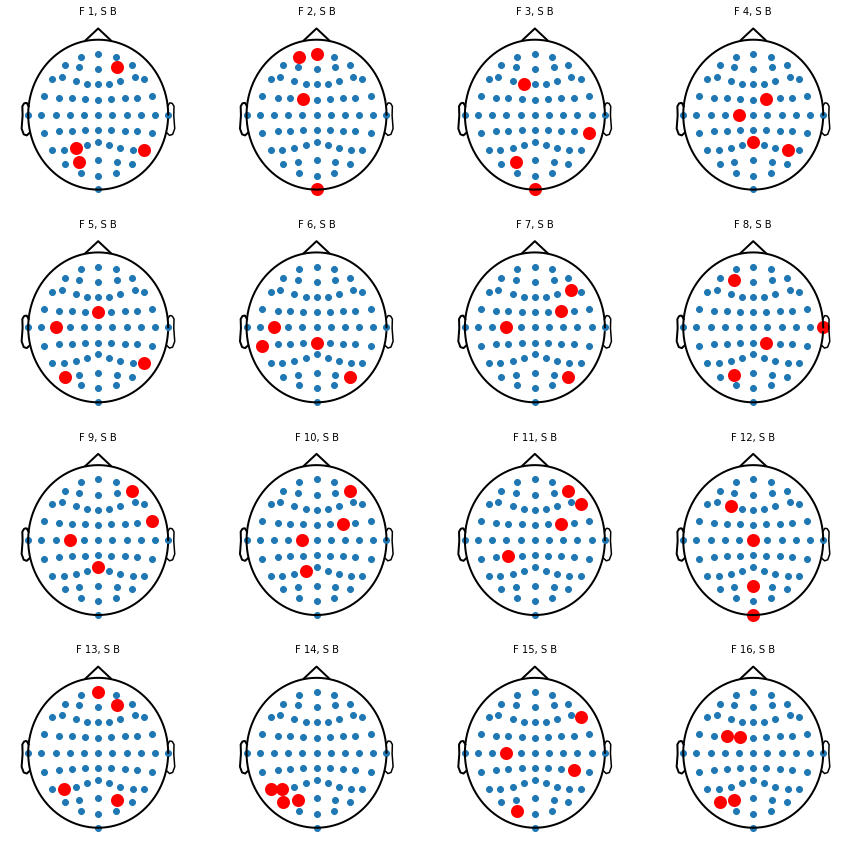

In [ ]:
plt.figure(figsize = (15, 15))
k = 0
subject = 'B'
for i in range(16):
  plt.subplot(4,4,k+1)

  # code of the function
  plot_electrodes(CHANNEL_LOCATIONS_FILE_PATH, ELOC64_BCI_DATASETII, idx[i])
  plt.title(f'F {i+1}, S {subject}', fontsize=10)
  k=k+1

## LOFO Electrode Importance


In [ ]:
#nested cicles in order to manage RAM
# Leave-One-Feature-Out LOFO
OneOutScore = []
for i in tqdm(range(0,64),desc='Channels'):
  newX = epochs_TRAIN.copy()
  newX[:,:,i] = 0   #newX[:,:,i] = np.random.normal()
  OneOutScore.append(model.evaluate(newX, labels_TRAIN, batch_size=64, verbose=0))
  gc.collect()
OneOutScore = pd.DataFrame(OneOutScore[:])
ordered_accuracy = np.argsort(OneOutScore.iloc[:,1])  #from most important (first element) to least imp channel
ordered_loss = np.argsort(-OneOutScore.iloc[:,0])     #from most important (first element) to least imp channel

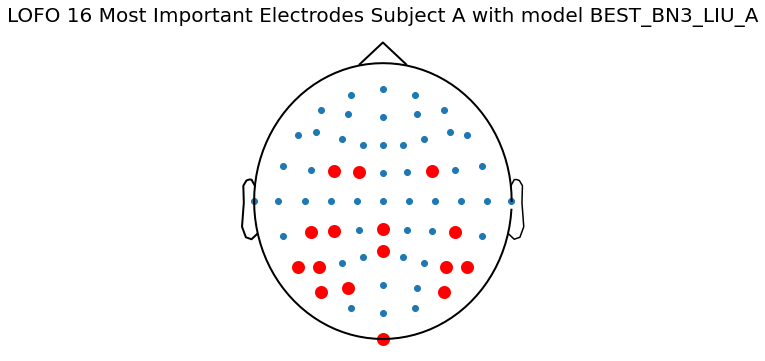

In [ ]:
#remember to define plot_electrodes function before executing the cell
#Sixteen mosto important electrodes according to LOFO analysis
ordered_accuracy_16=ordered_accuracy[0:16]
plt.figure(figsize = (6, 6))
# code of the function
plot_electrodes(CHANNEL_LOCATIONS_FILE_PATH, ELOC64_BCI_DATASETII, ordered_accuracy_16)
plt.title(f'LOFO 16 Most Important Electrodes Subject {subject} with model {model_to_use}', fontsize=20);

In [ ]:
LOFO_input=epochs_TRAIN.copy()
accuracy_LOFO=[]
for i in tqdm(range(0,64)):
  accuracy_LOFO.append(model.evaluate(LOFO_input, labels_TRAIN, batch_size=64, verbose=0))
  LOFO_input[:,:,ordered_accuracy[64-(i+1)]]=0
  gc.collect()

In [ ]:
#10-20 system accuracy
input_10_20=np.random.normal(size=[25500,160,64])
input_10_20[:,:,CHANNELS.index('Fp1')]=epochs_TRAIN[:,:,CHANNELS.index('Fp1')]
input_10_20[:,:,CHANNELS.index('Fp2')]=epochs_TRAIN[:,:,CHANNELS.index('Fp2')]
input_10_20[:,:,CHANNELS.index('F7')]=epochs_TRAIN[:,:,CHANNELS.index('F7')]
input_10_20[:,:,CHANNELS.index('F3')]=epochs_TRAIN[:,:,CHANNELS.index('F3')]
input_10_20[:,:,CHANNELS.index('Fz')]=epochs_TRAIN[:,:,CHANNELS.index('Fz')]
input_10_20[:,:,CHANNELS.index('F4')]=epochs_TRAIN[:,:,CHANNELS.index('F4')]
input_10_20[:,:,CHANNELS.index('F8')]=epochs_TRAIN[:,:,CHANNELS.index('F8')]
input_10_20[:,:,CHANNELS.index('C3')]=epochs_TRAIN[:,:,CHANNELS.index('C3')]
input_10_20[:,:,CHANNELS.index('Cz')]=epochs_TRAIN[:,:,CHANNELS.index('Cz')]
input_10_20[:,:,CHANNELS.index('C4')]=epochs_TRAIN[:,:,CHANNELS.index('C4')]
input_10_20[:,:,CHANNELS.index('P3')]=epochs_TRAIN[:,:,CHANNELS.index('P3')]
input_10_20[:,:,CHANNELS.index('Pz')]=epochs_TRAIN[:,:,CHANNELS.index('Pz')]
input_10_20[:,:,CHANNELS.index('P4')]=epochs_TRAIN[:,:,CHANNELS.index('P4')]
input_10_20[:,:,CHANNELS.index('O1')]=epochs_TRAIN[:,:,CHANNELS.index('O1')]
input_10_20[:,:,CHANNELS.index('O2')]=epochs_TRAIN[:,:,CHANNELS.index('O2')]
accuracy_10_20=model.evaluate(input_10_20, labels_TRAIN, batch_size=64, verbose=0)
accuracy_10_20=np.ones(64)*accuracy_10_20[1]

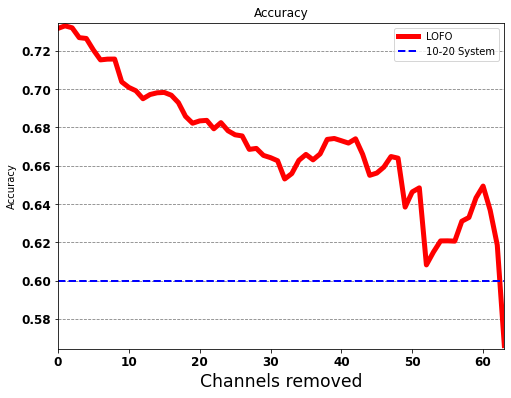

In [ ]:
#Convert accuracy list into array
accuracy_LOFO=np.array(accuracy_LOFO)
# Initialize the figure and subplot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

# Set the font size via a keyword argument
ax.set_title("Accuracy", fontsize='large')
plt.ylabel('Accuracy')
plt.xlabel('Channels removed',fontsize='xx-large')
plt.margins(0,0.01)
ax.yaxis.grid(color='gray', linestyle='dashed')

# Retrieve an element of a plot and set properties
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize('large')
    tick.set_color('black')
    tick.set_weight('bold')

for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize('large')
    tick.set_color('black')
    tick.set_weight('bold')  

ax.plot(accuracy_LOFO[:,1],'r',linewidth=5,label='LOFO')

ax.plot(range(0,64),accuracy_10_20,'b--',linewidth=2,label='10-20 System')
leg = ax.legend()